In [1]:
pip install pysrt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import re
import pyspark
import glob
import os

import pysrt

In [18]:
df = pd.read_excel('movies_labels.xlsx')

In [4]:
df

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+
...,...,...,...
236,236,Matilda(2022),C1
237,237,Bullet train,B1
238,238,Thor: love and thunder,B2
239,239,Lightyear,B2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      241 non-null    int64 
 1   Movie   241 non-null    object
 2   Level   241 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.8+ KB


In [6]:
df.Movie.value_counts()

Powder(1995)                 2
The_terminal(2004)           2
The_blind_side(2009)         2
Inside_out(2015)             2
10_Cloverfield_lane(2016)    1
                            ..
The_hangover(2009)           1
The_holiday(2006)            1
The_invisible_man(2020)      1
The_jungle_book(2016)        1
The Grinch                   1
Name: Movie, Length: 237, dtype: int64

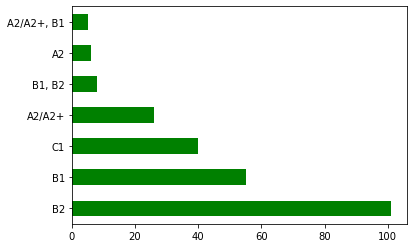

In [7]:
df.Level.value_counts().plot(kind='barh', color='g');

На диаграмме видно, что необходимо корректно изменить категории, разделив фильмы из смежных категорий по основным уровням знания языка.

In [8]:
#x = r"([1-9,0,(),_]+)"
#x = df.Movie.str.replace(x, ' ')
#
#x = x.str.strip()
#x.unique()

In [9]:
df[df['Movie'].duplicated()]

,id,Movie,Level
44,44,Inside_out(2015),B1
68,68,Powder(1995),B1
84,84,The_blind_side(2009),B1
99,99,The_terminal(2004),"A2/A2+, B1"


In [10]:
df = df.drop_duplicates(subset = 'Movie')
df[df['Movie'].duplicated()]

,id,Movie,Level


Добавим все субтитры

In [11]:
del_n = re.compile('\n')                # перенос каретки
del_tags = re.compile('<[^>]*>')        # html-теги
del_brackets = re.compile('\([^)]*\)')  # содержимое круглых скобок
clean_text = re.compile('[^а-яa-z\s]')  # все небуквенные символы кроме пробелов
del_spaces = re.compile('\s{2,}')

def prepare_text(text):
    text = del_n.sub(' ', str(text).lower())
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)
    res_text = clean_text.sub('', text)
    return del_spaces.sub(' ',res_text)

def del_stopwords(text):
    clean_tokens = tuple(
        map( lambda x: x if x not in stop_words else '', word_tokenize(text) )
    )
    res_text = ' '.join(clean_tokens)
    return res_text

def lemmatize(text):    
    lemmatized_text = ''.join(m.lemmatize(text))
    return lemmatized_text.split('|')

In [12]:
path = 'Subtitles_all'

def import_subs(folder):
    sub_labels = []
    subs = []
    for films in glob.glob(os.path.join(path + '\\' + folder, '*.srt')): # 'Subtitles'
        sub_labels.append(films)
        for i in range(len(sub_labels)):
            subs.append(pysrt.open(sub_labels[i], encoding = 'iso-8859-1').text)
    return subs

In [16]:
a_2 = import_subs('A2')
a_

prepare_text(a_2)

'nn n nnnnnnlittle girlnim a policemannlittle girlndont be afraid okaynlittle girlnnnoh my godnn n man whats the differencen n man whats the differencenbetween men and womenn man this a joken no im seriousnman i never met a womannwho knew how to turn off a lightntheyre born thinkingnthe switch only goes one wayn onn ntheyre struck blindnthe second they leave a roomni mean every womanni ever let have a keyni swear to godnits like i come homenhouse all lit upnnand my jobnyou see apparentlynbecause my chromosomesnhappen to be differentnis ive then gotta walknthrough that housenturn off every single lightnthis chick left onn is that rightn yeah baby mmmnoh reverend shane isnpreaching to you now boynnthen the same chick mind younshell bitch about global warmingnyou see this is this isnwhen reverend shane wantsnto quote fromnthe guy gospel and sayndarling maybe you and every othernpair of boobs on this planetnjust figure out the light switchnyou see goes both waysnmaybe we wouldnt have so mu